# **MRI Brain Tumour Segmentation**

Here we will be implementing Fully Convolutional Networks (FCNs) for the task of semantic segmentation for extracting the brain tumour from MRI scans.

### **Contents**

1. Loading the dataset
2. Visualising the dataset
3. Splitting data into Train, Validation sets
4. Data Augmentation
5. Define Required Loss Functions and Testing Metrics
6. Building the FCN with Keras
7. Set hyperparameters and compile the model
8. Training the model
9. Evaluate the model
10. Visualise the results


In [ ]:
#Necessary Imports
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

## Loading the Dataset

On Google Colab, you can clone the dAIgnose repo that you have forked, so that the dataset is available on your working directory.

In [ ]:
!git clone https://github.com/SubarnoNR/Hello-FOSS-Image-Segmentation.git

In [ ]:
DATASET_PATH = '/content/Hello-FOSS-Image-Segmentation/Dataset/' #Replace with your correct dataset path

train_files = []
mask_files = glob.glob(f'{DATASET_PATH}*/*_mask*')
train_files = [x.replace('_mask','') for x in mask_files]

#To ensure the files have been loaded correctly
print(train_files[:10])
print(mask_files[:10])

['/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_3.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_16.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_21.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_10.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_26.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_11.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_22.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_36.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_23.tif', '/content/Hello-FOSS-Image-Segmentation/Dataset/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206

## Visualising the dataset

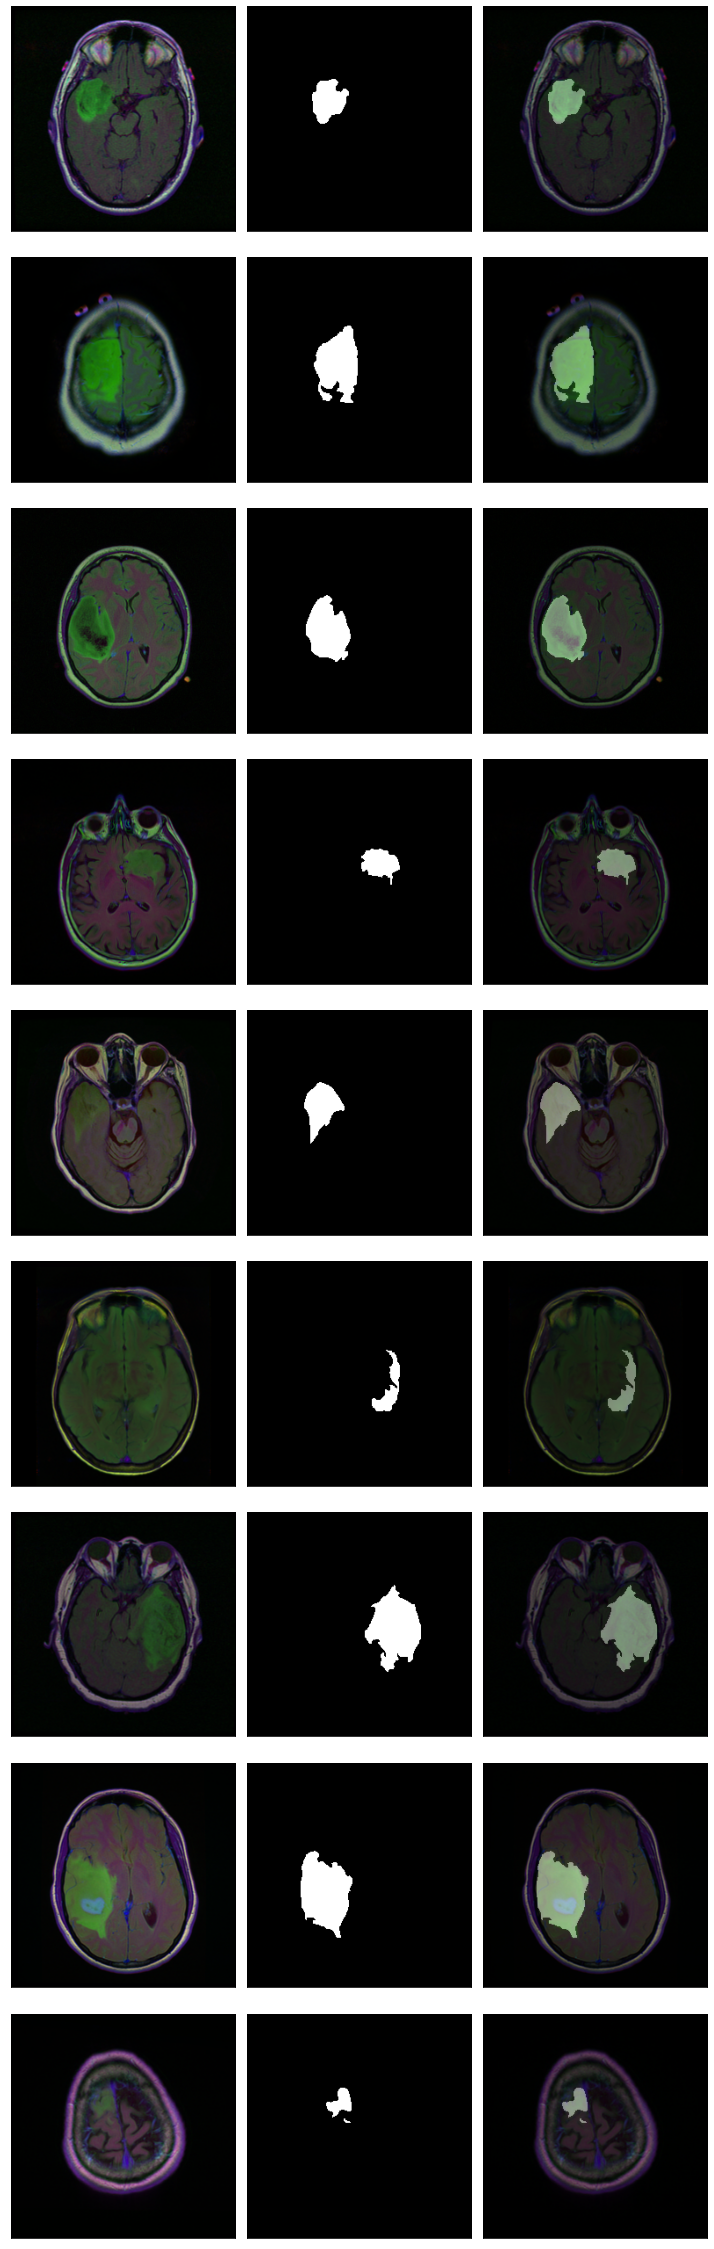

In [ ]:
#Displaying Images with Brain Tumours along with their masks
fig=plt.figure(figsize=(10,35))
for i in range(1,10):
    ind = random.randint(0,len(train_files)-1)
    img_path=train_files[ind]
    mask_path=mask_files[ind]
    mask=cv2.imread(mask_path)
    while np.sum(mask)==0 :
      ind = random.randint(0,len(train_files)-1)
      img_path=train_files[ind]
      mask_path=mask_files[ind]
      mask=cv2.imread(mask_path)
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig.add_subplot(10,3,i*3+1)
    plt.imshow(img)
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(10,3,i*3+2)
    plt.imshow(mask)
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(10,3,i*3+3)
    plt.imshow(img)
    plt.imshow(mask,alpha=0.4)
    plt.xticks([]); plt.yticks([]) 
fig.tight_layout()   
plt.show()

## Splitting Data into Train and Validation sets

We split the data into:
- Training Set : 90%
- Test Set : 10%

The Training set is further split into :
- Train Set : 80%
- Validation Set : 20%

In [ ]:
df=pd.DataFrame(data={"filename":train_files,"mask":mask_files})
df_train,df_test=train_test_split(df,test_size=0.1)
df_train,df_val=train_test_split(df_train,test_size=0.2)
print(df_train.shape, df_val.shape, df_test.shape)

(2828, 2) (708, 2) (393, 2)


## **Data Augmentation**

We will be using [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) from the preprocessing module of Keras on the dataframes created for training, testing and validation set using [flow_from_dataframe](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe). The dataset can also be modified and improved to better train the model. 

Use data augmentation techniques, rotate, translate and warp images to improve the diversity of images being used for training. This will help solve any overfitting issues and help boost up accuracy.

In [ ]:
def train_generator(data_frame, batch_size,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256,3),
        seed=1):

    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

## **Define Loss Functions and Testing Metrics**

Here we define the functions for Dice Loss and IoU(Intersection over Union) using keras.backend. You can read more about these from [Dice Loss](https://www.fatalerrors.org/a/dice-loss-in-medical-image-segmentation.html) and [IoU](https://www.jeremyjordan.me/evaluating-image-segmentation-models/).

The function for Dice Loss has already been defined, similarly define the function for IoU. You can also read about and use other loss functions for semantic segmentation given [here](https://arxiv.org/pdf/2006.14822.pdf)

In [ ]:
smooth=100

def dice_coef_loss(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return -((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))


def iou(y_true, y_pred):
   """ Add your code for calculating IOU here """


## **Constructing the Model**

A very simple UNet has been implemented over here. As you will see later, this does give very high binary accuracy, which is a misleading metric for the task of semantic segmentation that we have. IoU results will show that the model needs a lot of improvement. Thus add/modify the layers, adjust the hyperparameters and try to improve the model for better IOU.





In [ ]:
def create_model(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3),activation='relu', padding='same')(inputs)
    bn1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    bn2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    up1 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(pool2), conv2], axis=3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

    up2 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv3), conv1], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    conv5 = Conv2D(1, (1, 1), activation='sigmoid')(conv4)

    return Model(inputs=[inputs], outputs=[conv5])

##  **Setting Hyperparameters and compiling the model**



In [ ]:
EPOCHS = 3
BATCH_SIZE = 32
LEARNING_RATE = 0.01
IMAGE_SIZE = (256, 256)

In [ ]:
train_gen = train_generator(df_train, BATCH_SIZE, target_size=IMAGE_SIZE)
    
test_gener = train_generator(df_val, BATCH_SIZE, target_size=IMAGE_SIZE)
    
model = create_model(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou])

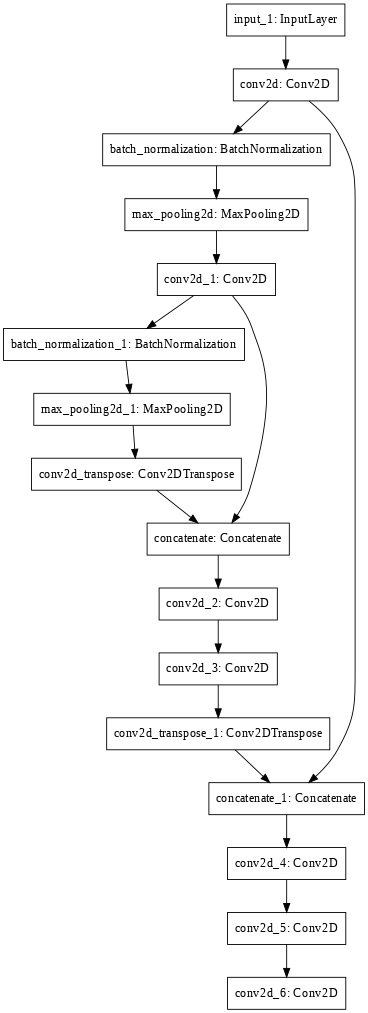

In [ ]:
tf.keras.utils.plot_model(model,dpi=64)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## **Training the model**



In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/3
89/88 [==============================] - ETA: 0s - loss: -0.0178 - binary_accuracy: 0.9734 - iou: 0.0131Found 708 validated image filenames.
Found 708 validated image filenames.
88/88 [==============================] - 126s 965ms/step - loss: -0.0178 - binary_accuracy: 0.9734 - iou: 0.0131 - val_loss: -0.0049 - val_binary_accuracy: 0.9890 - val_iou: 0.0052
Epoch 2/3
88/88 [==============================] - 79s 895ms/step - loss: -0.0052 - binary_accuracy: 0.9898 - iou: 0.0053 - val_loss: -0.0048 - val_binary_accuracy: 0.9887 - val_iou: 0.0055
Epoch 3/3
88/88 [==============================] - 79s 896ms/step - loss: -0.0053 - binary_accuracy: 0.9898 - iou: 0.0056 - val_loss: -0.0049 - val_binary_accuracy: 0.9888 - val_iou: 0.0060


## **Evaluate the Model**

In [ ]:
#Using the 'history' object, plot graphs for binary accuracy, diceloss, IoU and other metrics you have defined
#earlier over the number of epochs.
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'iou', 'val_loss', 'val_binary_accuracy', 'val_iou'])


## **Visualise the Results**

In [ ]:
#Original Image  #Actual Mask  #Predicted Masks